# Title

## EDA

In [1]:
#import the packages
import sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [2]:
df = pd.read_csv('data/AS24_Punto_Evo.csv', index_col=0)

In [3]:
df.head()

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price
0,Fiat Punto Evo,1.4 5 porte Dynamic EasyPower,"['Sedile posteriore sdoppiato, Fendinebbia']",218000,09/2011,57 kW (77 CV),Usato,1.0,Manuale,GPL,3390
1,Fiat Punto Evo,1.2 3 porte Active,"['Specchietti laterali elettrici, Antifurto']",176539,11/2011,48 kW (65 CV),Usato,NaN,Manuale,Benzina,3900
2,Fiat Punto Evo,Punto Evo 1.2 Dynamic s,"['Volante in pelle, Computer di bordo, Chiusur...",159000,01/2012,51 kW (69 CV),Usato,NaN,Manuale,Benzina,4500
3,Fiat Punto Evo,1.6 Mjt DPF 3 porte Sport,"['Fendinebbia, Pacchetto sportivo, Chiusura ce...",197000,04/2010,88 kW (120 CV),Usato,NaN,Manuale,Diesel,4900
4,Fiat Punto Evo,1.2 3 porte S&S Dynamic,"['Cerchi in lega, Climatizzatore, Autoradio, C...",59900,06/2012,51 kW (69 CV),Usato,NaN,Manuale,Benzina,5900


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   model       400 non-null    object 
 1   version     390 non-null    object 
 2   equipments  8 non-null      object 
 3   mileage     400 non-null    int64  
 4   mmyy        400 non-null    object 
 5   power       400 non-null    object 
 6   use_type    400 non-null    object 
 7   n_owners    99 non-null     float64
 8   gear        400 non-null    object 
 9   fuel_type   400 non-null    object 
 10  price       400 non-null    int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 37.5+ KB


In [5]:
df.describe()

,mileage,n_owners,price
count,400.000000,99.000000,400.000000
mean,159656.597500,1.222222,4598.672500
std,46177.099492,0.441601,897.461522
min,46000.000000,1.000000,1500.000000
25%,130000.000000,1.000000,4000.000000
50%,156000.000000,1.000000,4600.000000
75%,186678.250000,1.000000,5362.250000
max,419000.000000,3.000000,6500.000000


'equipments' and 'n_owners' have very few non-null values. We neglect these features.
'version' seems to hold many different car's features (226, to be precise). We neglect it for now.

### Check the power column

In [6]:
df.power.value_counts()

51 kW (69 CV)     108
55 kW (75 CV)      91
57 kW (77 CV)      85
70 kW (95 CV)      55
48 kW (65 CV)      25
66 kW (90 CV)      12
77 kW (105 CV)      9
88 kW (120 CV)      7
99 kW (135 CV)      3
62 kW (84 CV)       2
75 kW (102 CV)      1
95 kW (129 CV)      1
63 kW (86 CV)       1
Name: power, dtype: int64

Power has 23 different values. Let's set a kW column

In [7]:
df['kW'] = df['power'].apply(lambda x: int(x.split()[0]))

### Check the 'fuel' column

In [8]:
df.fuel_type.value_counts()

Diesel     170
Benzina    114
GPL         58
Metano      57
Altro        1
Name: fuel_type, dtype: int64

In [9]:
#what is 'altro'?
boole = df.fuel_type == 'Altro'
df[boole]

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW
175,Fiat Punto Evo,1.4 Natural Power Dynamic,NaN,125000,06/2010,57 kW (77 CV),Usato,NaN,Manuale,Altro,4500,57


'altro' means clearly 'Metano'. Let's set it.

In [10]:
df.loc[175,'fuel_type'] = 'Metano'

### Check the 'use_type' column

In [11]:
df.use_type.unique()

array(['Usato', 'Aziendale'], dtype=object)

Here there is nothing to report.

### Check the 'gear' column

In [12]:
df.gear.unique()

array(['Manuale', '- (Tipo di cambio)', 'Automatico', 'Semiautomatico'],
      dtype=object)

we find '- (Tipo di cambio)' where the input was 'None'. I check the frequency:

In [13]:
#what's the gear distribution?
df['gear'].value_counts()

Manuale               373
- (Tipo di cambio)     15
Automatico              8
Semiautomatico          4
Name: gear, dtype: int64

In [14]:
#let'see is we get more info...
df[df.gear == '- (Tipo di cambio)']

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW
47,Fiat Punto Evo,sport,NaN,167000,11/2010,70 kW (95 CV),Usato,NaN,- (Tipo di cambio),Diesel,3500,70
60,Fiat Punto Evo,NaN,NaN,173241,09/2011,55 kW (75 CV),Usato,NaN,- (Tipo di cambio),Diesel,3500,55
147,Fiat Punto Evo,1.4 BENZINA -GPL,NaN,180000,03/2012,57 kW (77 CV),Usato,NaN,- (Tipo di cambio),GPL,4400,57
166,Fiat Punto Evo,1.2 S&S 3 porte,NaN,132000,04/2011,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),Benzina,4500,51
167,Fiat Punto Evo,1.2 S&S 3 porte,NaN,132000,04/2011,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),Benzina,4500,51
168,Fiat Punto Evo,1.2 S&S 3 porte,NaN,132000,04/2011,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),Benzina,4500,51
180,Fiat Punto Evo,NaN,NaN,155000,03/2010,51 kW (69 CV),Usato,1.0,- (Tipo di cambio),Metano,4500,51
217,Fiat Punto Evo,Lounge,NaN,167000,05/2012,55 kW (75 CV),Usato,NaN,- (Tipo di cambio),Diesel,4800,55
236,Fiat Punto Evo,emotion tetto apribile,NaN,181000,11/2012,51 kW (69 CV),Usato,NaN,- (Tipo di cambio),GPL,4900,51
260,Fiat Punto Evo,NaN,NaN,133000,08/2011,75 kW (102 CV),Usato,NaN,- (Tipo di cambio),Diesel,5000,75


The is no much information in the 'version' column to help. However, 'Manuale' is by far the most frequent. Let's use it.

In [15]:
df['gear'] = df['gear'].apply(lambda x: 'Manuale' if re.search('Tipo', x) else x)

### Check the 'mmyy' column

In [16]:
#transform it into datetime format
df['mmyy'] = df['mmyy'].apply(pd.to_datetime)
#compute an 'age' column
now = pd.to_datetime('11/2021')
df['age']  = (now - df.mmyy) / np.timedelta64(1, 'Y')

In [17]:
df.describe()

,mileage,n_owners,price,kW,age
count,400.000000,99.000000,400.000000,400.000000,400.000000
mean,159656.597500,1.222222,4598.672500,57.907500,10.511646
std,46177.099492,0.441601,897.461522,9.188581,0.957669
min,46000.000000,1.000000,1500.000000,48.000000,6.505267
25%,130000.000000,1.000000,4000.000000,51.000000,10.001574
50%,156000.000000,1.000000,4600.000000,55.000000,10.587486
75%,186678.250000,1.000000,5362.250000,57.000000,11.167923
max,419000.000000,3.000000,6500.000000,99.000000,13.919519


In [18]:
#there is a strange old car. These cars were produced starting from 2009
df[df.mmyy< '01/2009']

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age
212,Fiat Punto Evo,Punto Evo 1.2 Active 65cv 5p,NaN,160000,2007-12-01,48 kW (65 CV),Usato,NaN,Manuale,GPL,4700,48,13.919519


Here there must be a mistake: this car was sold starting from 2009, thus the year 'mmyy' can't be 2007. If we believe that the claimed power (48kW) is correct, then  this car was sold between 2009 and 2010 (we found this out after a short searching on the net). We fix it by setting the 'mmyy' value to the approximate date 12/2009.

In [19]:
df.loc[212,'mmyy'] = '2009-12-01'

### Variables discussion

The interesting variables we believe can affect the price are: mileage, power, kW, and age. However, the power and the gear type may affect it as well. Let's check them

<IPython.core.display.Javascript object>


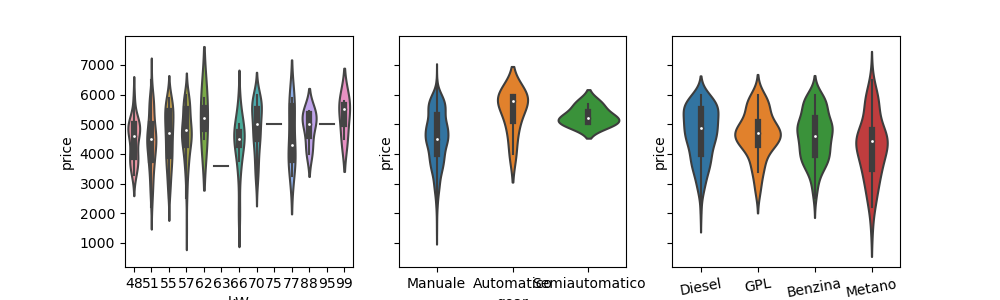

In [20]:
f, ax = plt.subplots(figsize=(10, 3), nrows=1, ncols=3, sharey=True)
sns.violinplot(x='kW', y='price', data=df, ax=ax[0])
g = sns.violinplot(x='gear', y='price', data=df,ax=ax[1], rot=90)
plt.xticks(rotation=10)
g = sns.violinplot(x='fuel_type', y='price', data=df,ax=ax[2], rot=90, order=['Diesel','GPL','Benzina','Metano'])

There is a light correlation for kW, and a little more for gear type. Fuel type seems to affect the price at smaller degree. Let's see their median prices ordered by descending order:

In [21]:
df[['price','fuel_type']].groupby('fuel_type').agg('median').sort_values(by='price', ascending=False)

,price
fuel_type,
Diesel,4875
GPL,4700
Benzina,4600
Metano,4445


Let's use them by transforming them into values

In [22]:
encode_gear_dict = {'Manuale':1, 'Semiautomatico':2, 'Automatico':3}
encode_fuel_dict = {'Metano':1, 'Benzina':2, 'GPL':3,'Diesel':4}
df['gear_encoded'] = df['gear'].apply(lambda x: encode_gear_dict[x])
df['fuel_encoded'] = df['fuel_type'].apply(lambda x: encode_fuel_dict[x])

### Correlations check

<IPython.core.display.Javascript object>


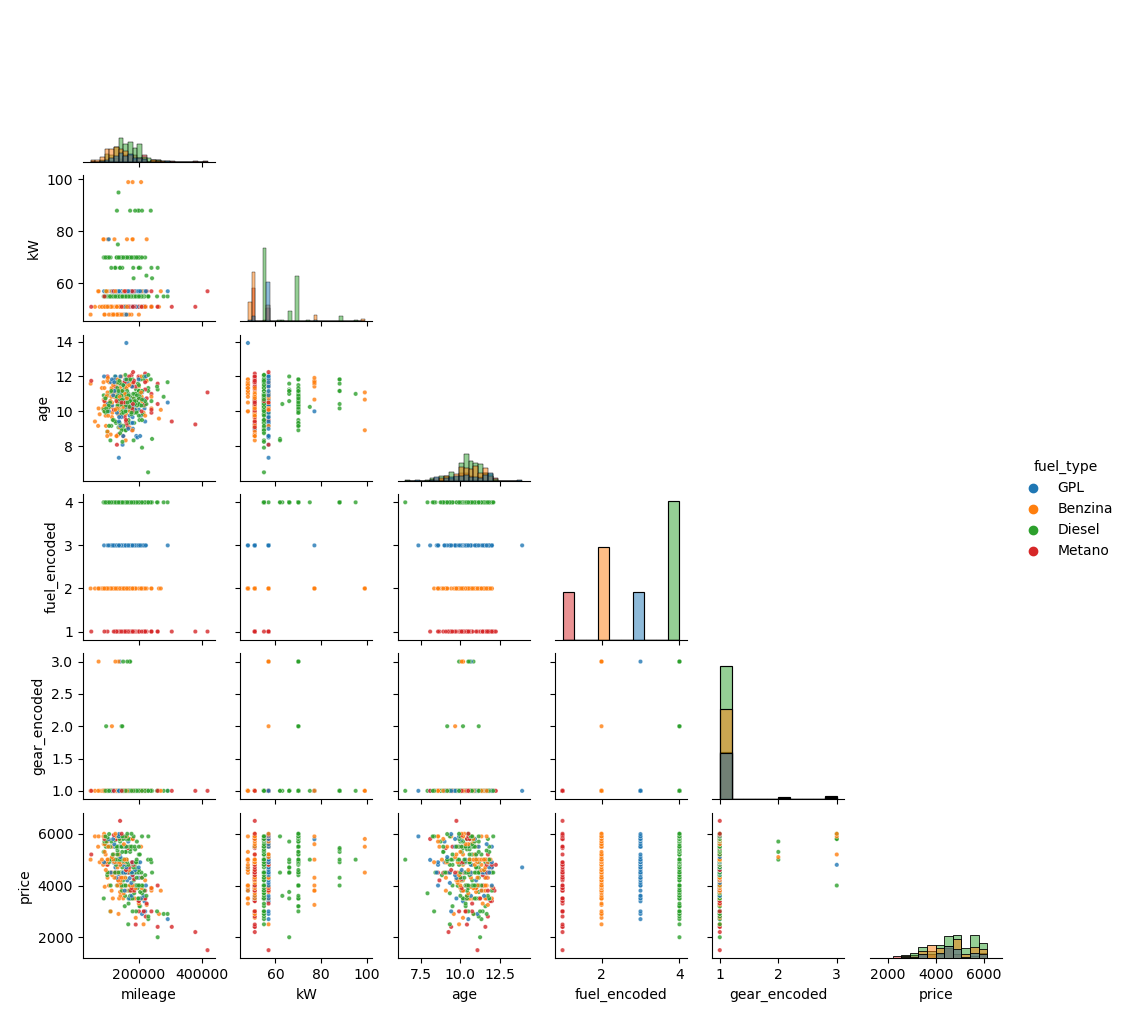

In [23]:
feat = ['mileage','power','kW','age','fuel_encoded','gear_encoded','price', 'fuel_type']
#f, ax = plt.subplots(figsize=(5, 5))
sns.pairplot(df[feat], hue="fuel_type", height=1.7, diag_kind="hist", corner=True, plot_kws={"s": 10, 'alpha':0.8})

<IPython.core.display.Javascript object>


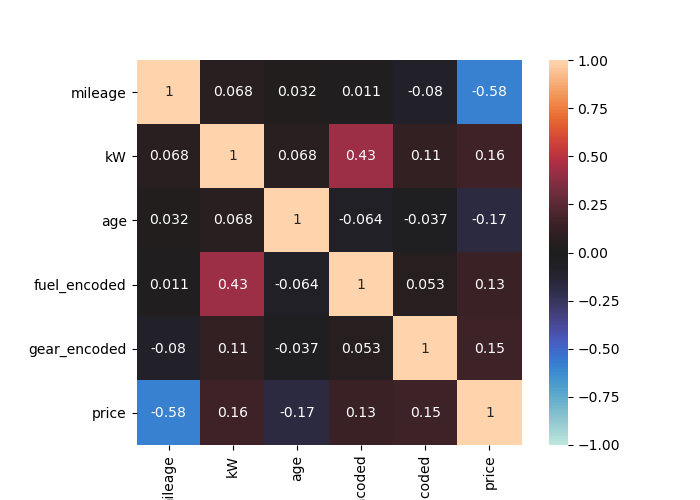

In [24]:
f, ax = plt.subplots(figsize=(7, 5))
df_corr = df[['mileage','kW','age','fuel_encoded','gear_encoded','price']].corr()
ax = sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1, center=0, square=True)

## Discussion on correlation values

We have just seen the correlation between the variables. We discuss them here shortly:
+ the correlation mileage-price is clearly the most important one, pointed out by the correlation matrix but also visible by eye on the previous plots
+ kW and age vs. price have weak positive and negative correlations, respectively
+ gear tyte show a weak correlation
+ fuel type shows also a positive correlation vs. price

Given that the car of our customer has manual gear and GPL fuel type, this bring us to the following considerations.
+ most of the cars have manual gear, and very few have a Semi- or Automatic gear. Besides, the latter have in average higher price. Thus, it is a good idea to drop Semi- and Automatic gear cars.
+ Similarly, we may be tempted to drop all the cars that are not GPL fuel type. Doing so, we would have left with a poor sample (58 cars). Besides, the average difference in car's price of the different fuel type is small. Thus, we decided to keep in the sample cars with any fuel type.


In [25]:
#drop the cars with fuel type equal to "Semiautomatico" and "Automatico"
index_to_drop = df.index[df['gear'] != 'Manuale']
df.drop(index=index_to_drop, inplace=True)
#we also drop two outliers for mileage>350000
index_to_drop = df.index[df['mileage'] > 350000]
df.drop(index=index_to_drop, inplace=True)

<IPython.core.display.Javascript object>


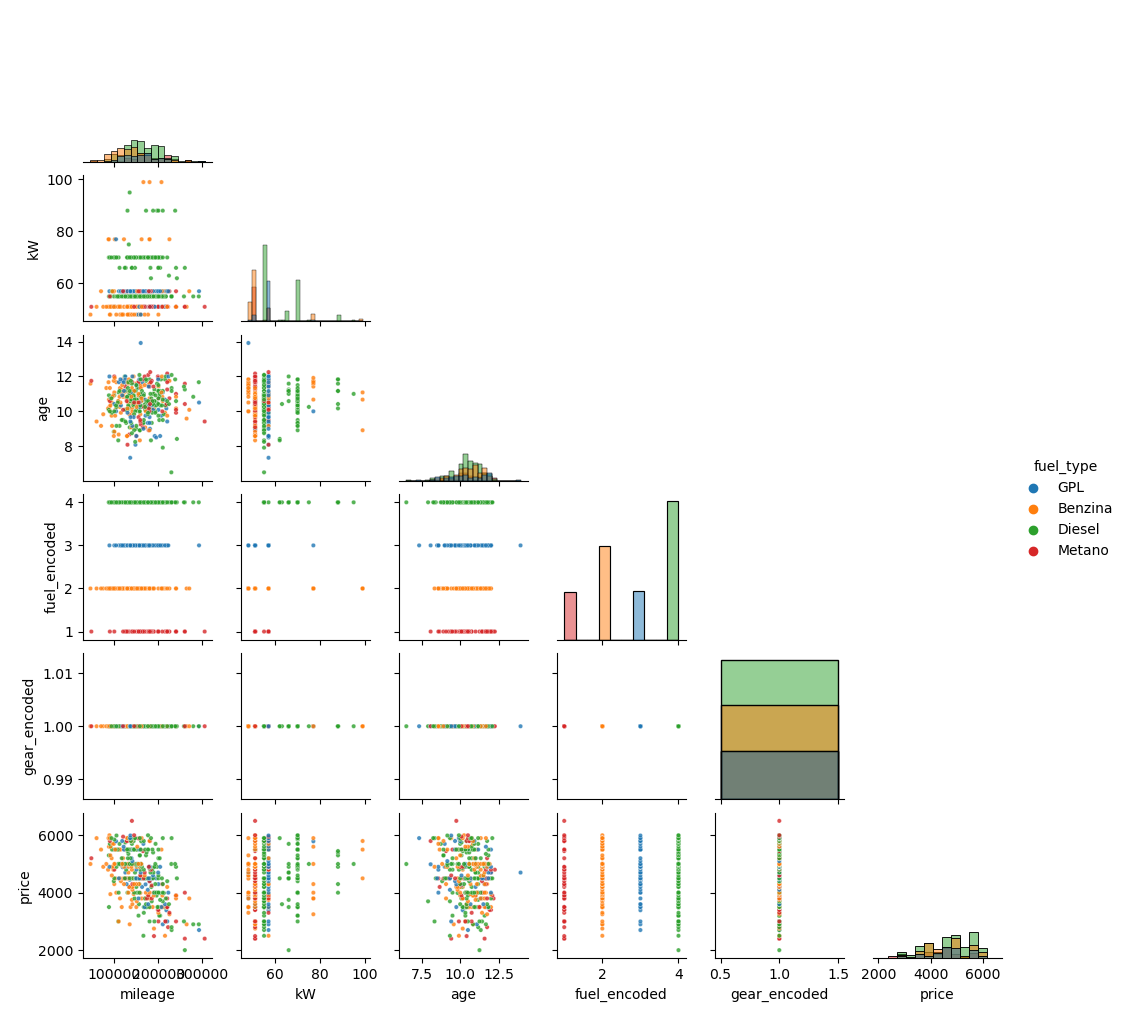

In [26]:
feat = ['mileage','power','kW','age','fuel_encoded','gear_encoded','price', 'fuel_type']
#f, ax = plt.subplots(figsize=(5, 5))
sns.pairplot(df[feat], hue="fuel_type", height=1.7, diag_kind="hist", corner=True, plot_kws={"s": 10, 'alpha':0.8})

## Set the ML model

We set here the ML model in order to esteem the market price of the customer's car.

In [143]:
#upload the necessary python packages
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#we consider only the following features
features = ['mileage','age','kW','fuel_encoded']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'], test_size=0.2, random_state = 42)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2)

After some tests, during which we used ML models such as Random Forest, Gradient Boosting Regressor, and KNeighbors Regressor, we choose to use a simple linear regressor together with a scaler and polynomial features to model the shape of the distribution seen in previous figures. By using a pipeline and hyperparameters grid searcher, we procede as follow:

In [183]:
hist_val, bins = np.histogram(df.price.values,bins=45)
hist_val = np.where(hist_val,0,1)
which_bin = np.digitize(df.price.values, bins)
weights = 1./hist_val

(array([ 1,  0,  0,  0,  3,  2,  0,  3,  2,  6,  9,  0,  4,  4,  4, 20,  6,
         5, 13, 14, 18,  2, 12, 10, 10, 47,  5,  9, 13, 30, 24,  1,  9,  7,
         5, 36,  6,  9, 12, 22,  2,  0,  0,  0,  1]),
 array([2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800.,
        2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700.,
        3800., 3900., 4000., 4100., 4200., 4300., 4400., 4500., 4600.,
        4700., 4800., 4900., 5000., 5100., 5200., 5300., 5400., 5500.,
        5600., 5700., 5800., 5900., 6000., 6100., 6200., 6300., 6400.,
        6500.]))

In [164]:
ridge = Ridge(normalize=True)
poly = PolynomialFeatures(include_bias=False)
scaler = StandardScaler()

n_samples / (n_classes * np.bincount(y))

pipe = Pipeline(steps=[('scaler', scaler),('poly', poly),('linreg', ridge)])

dict_params = {'linreg__alpha' :  [0.01, 0.1, 1, 3, 10,30,100,300], 'poly__degree': [1,2,3]}
grid_search = GridSearchCV(pipe, dict_params, cv = kfold, scoring='r2')
grid_search.fit(X_train,y_train)

/home/corrado/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linreg', Ridge(normalize=True))]),
             param_grid={'linreg__alpha': [0.01, 0.1, 1, 3, 10, 30, 100, 300],
                         'poly__degree': [1, 2, 3]},
             scoring='max_error')

In [159]:
model = KNeighborsRegressor()
scaler = StandardScaler()

pipe = Pipeline(steps=[('scaler', scaler),('model', model)])

dict_params = {'model__n_neighbors' :  [3, 5,10], 'model__weights': ['uniform', 'distance']}

grid_search = GridSearchCV(pipe, dict_params, cv = kfold, scoring='r2')
grid_search.fit(X_train,y_train)

/home/corrado/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__n_neighbors': [3, 5, 10],
                         'model__weights': ['uniform', 'distance']},
             scoring='r2')

In [148]:
model = GradientBoostingRegressor(max_features='auto')
dict_params = {'n_estimators': [500,1000,2000], 'max_depth': [1,2,3,4,5,6]}

grid_search = GridSearchCV(model, dict_params, cv = kfold, scoring='r2')
grid_search.fit(X_train,y_train)

/home/corrado/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=2, shuffle=True),
             estimator=GradientBoostingRegressor(max_features='auto'),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [500, 1000, 2000]},
             scoring='r2')

In [165]:
print('best parameters: {}'.format(grid_search.best_params_))
print('best R2 score: {:.2f}'.format(grid_search.best_score_))

best parameters: {'linreg__alpha': 1, 'poly__degree': 2}
best R2 score: -2122.59


In [166]:
print('X_test R2 score: {:.2f}'.format(grid_search.score(X_test,y_test)))

X_test R2 score: -1525.35


We want now to check by eye that the predicted value make sense. Let's see the distribution on the predicted differences "predicted minus true"

<IPython.core.display.Javascript object>


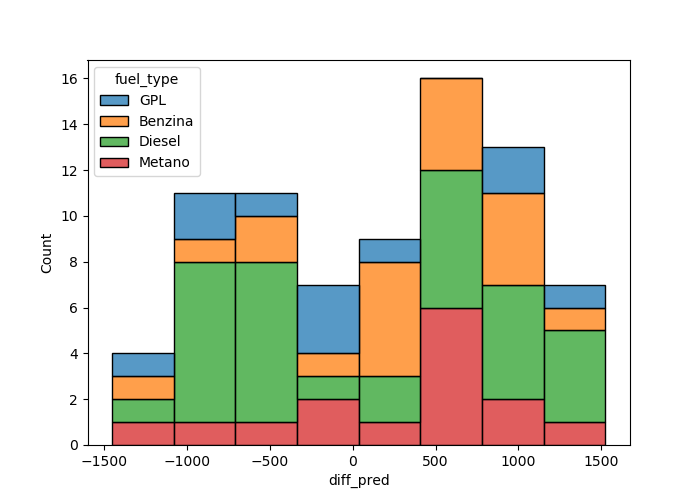

In [167]:
y_pred = grid_search.predict(X_test)
df['diff_pred'] = y_pred - y_test

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.histplot(x='diff_pred', hue='fuel_type', multiple='stack', data=df)

The differences look fairly distributed around zero. Let's check now the mileage vs. price of the whole data set in comparison with the predicted price

<IPython.core.display.Javascript object>


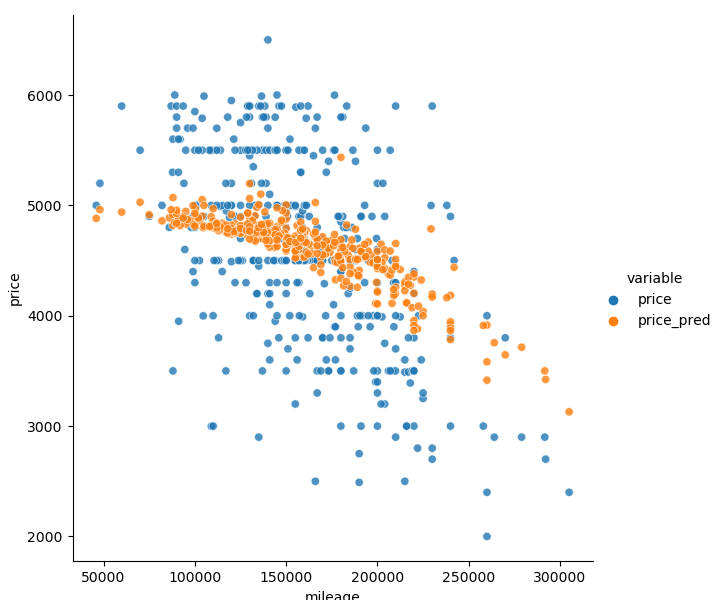

In [168]:
#predict the price
df['price_pred'] = grid_search.predict(df[features])
#shape a dataframe to fit the sns relplot

df_melt = pd.melt(df,id_vars=['mileage'], value_vars=['price','price_pred'])
df_melt.rename(columns={'value':'price'}, inplace=True)

sns.relplot(x="mileage", y="price", hue="variable", sizes=(40, 400), alpha=.8, height=6, data=df_melt)

In [126]:
customer_car = df.loc[[1]].copy()
customer_car['mileage'] = 160000
customer_car['age'] = 11
customer_car['fuel_encoded'] = 3

In [127]:
grid_search.predict(customer_car[features])

array([4906.1958543])